In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

%matplotlib inline

# Read csv
search_table = pd.read_csv('./SearchTable.csv')

# Convert columns containing counts to integers (fill missing values with 0)
for count_col in [x for x in list(search_table.columns) if x.startswith('count_')]:
    search_table[count_col].fillna(0, inplace=True)
    search_table[count_col] = search_table[count_col].astype(int)


In [3]:
# Identify sources based on column starting with 'source_' in csv file
sources = [x[7:] for x in list(search_table.columns) if x.startswith('source_')]

# Define output columns - columns 'DOI', 'Group' and 'Source' must be included, all others are optional.
# Additional columns can be added as needed.
result_columns = ['Title',
                  'Abstract',
                  'Authors',
                  'DOI',  # Mandatory Column
                  'Year',
                  'Keywords',
                  'Type',
                  'Publication',
                  'Group',  # Mandatory Column
                  'Source'  # Mandatory Column
                  ]


In [4]:
column_maps = {}

# Define column mapping for each source. Columns with identical names do not need to be mapped.
# Columns not included in the search result files will be ignored.
# Column 'DOI' must be included in the search result file (or mapped).

# arXiv
column_maps['arXiv'] = {'Title': 'Title',
                        'Abstract': 'Abstract',
                        'Authors': 'Authors',
                        'DOI': 'DOI',
                        'Year': 'Year'}

# IEEE
column_maps['IEEE'] = {'Document Title': 'Title',
                       'Abstract': 'Abstract',
                       'Authors': 'Authors',
                       'DOI': 'DOI',
                       'Publication Year': 'Year',
                       'Publication Title': 'Publication',
                       'IEEE Terms': 'Keywords',
                       'Document Identifier': 'Type'}

# Scopus
column_maps['Scopus'] = {'Titles': 'Title',
                         'Abstract': 'Abstract',
                         'Authors': 'Authors',
                         'DOI': 'DOI',
                         'Year': 'Year',
                         'Source title': 'Publication',
                         'Indexed Keywords': 'Keywords',
                         'Document Type': 'Type'}


In [5]:
# Function to search arXiv and parse result xml format
# Any future API implementation requires a function accordingly, with the same parameters

import urllib
from io import StringIO
import xml.etree.ElementTree as ET


def search_arXiv(search_term_1: str, search_term_2: str, from_year: int = 2015) -> pd.DataFrame:

    # Perform API call, retrieve results
    search1 = search_term_1.replace(' ', '+')
    search2 = search_term_2.replace(' ', '+')
    url = f'http://export.arxiv.org/api/query?search_query=all:"{search1}"+AND+"{search2}"&start=0&max_results=10000'
    data = urllib.request.urlopen(url)
    data_as_string = data.read().decode('utf-8')

    # Parse resulting XML into a dataframe
    it = ET.iterparse(StringIO(data_as_string))
    for _, el in it:
        _, _, el.tag = el.tag.rpartition('}')  # strip ns
    root = it.root

    df = pd.DataFrame()

    for child in root:
        if child.tag == 'entry':
            new_entry = {}
            for entry in child:
                if entry.tag == 'title':
                    new_entry['Title'] = entry.text
                if entry.tag == 'summary':
                    new_entry['Abstract'] = entry.text
                if entry.tag == 'id':
                    new_entry['AID'] = entry.text
                if entry.tag == 'doi':
                    new_entry['DOI'] = entry.text
                if entry.tag == 'published':
                    new_entry['Year'] = int(entry.text[:4])
                if entry.tag == 'author':
                    for name in entry:
                        if name.tag == 'name':
                            try:
                                new_entry['Authors'] = new_entry['Authors'] + name.text + '; '
                            except KeyError:
                                new_entry['Authors'] = name.text + '; '
                if entry.tag == 'link':
                    if entry.attrib['rel'] == 'alternate':
                        new_entry['Link'] = entry.attrib['href']
            if 'Authors' in new_entry.keys():
                new_entry['Authors'] = new_entry['Authors'][:-2]
            if not 'DOI' in new_entry.keys():
                tmp = new_entry['AID'][new_entry['AID'].rfind('/') + 1:new_entry['AID'].rfind('v')]
                new_entry['DOI'] = '10.48550/arXiv.' + tmp
            if new_entry['Year'] >= from_year:
                df = df.append(new_entry, ignore_index=True)
    return df

In [6]:
# Define search functions per source

search_functions = {}

search_functions['arXiv'] = search_arXiv


In [7]:
# Prepare results

results = pd.DataFrame(columns=result_columns)

# Go by source
for source in sources:
    # Identify if expected result counts are provided for the respective source
    has_count_column = f'count_{source}' in search_table.columns
    if not has_count_column:
        print(f'WARNING: Column "count_{source}" not in csv file')

    # Go by row
    for i in search_table[search_table[f'source_{source}'] == True].index:
        search_id = search_table['ID'][i]
        group_id = search_table['Group'][i]

        # Check if a result csv is stored for the respective search ID, and if so, read it
        if os.path.isfile(f'./{source}/{search_id}.csv'):
            try:
                df = pd.read_csv(f'./{source}/{search_id}.csv')
            except pd.errors.EmptyDataError:
                df = None
        # Otherwise, check if an online search can be performed
        elif source in search_functions.keys():
            print(f'INFO: Executing search for {source}-{search_id}')
            df = search_functions[source](search_table['Term1'][i],
                                          search_table['Term2'][i],
                                          from_year = search_table['YearFrom'][i])
            df.to_csv(f'./{source}/{search_id}.csv', index=False)
        # If not, skip the row (warn if the expected result count is larget than 0)
        else:
            if has_count_column & search_table[f'count_{source}'][i] > 0:
                print(f'WARNING: Search result file not found for {source}-{search_id}')
            df = None

        # Add search results to consolidated results dataframe
        if df is not None:
            if has_count_column and search_table[f'count_{source}'][i] != len(df):
                expected = search_table[f'count_{source}'][i]
                print(f'WARNING: Mismatch in {source}-{search_id}: expected: {expected} | actual: {len(df)}')
            df = df.rename(columns=column_maps[source])
            df['Group'] = group_id
            df['Source'] = source
            results = pd.concat([results, df])
            results = results[result_columns]


In [8]:
# Identify list of Groups
groups = list(set(results['Group']))
groups.sort()

# Setup dataframe of de-duplicated DOI numbers
deduped = pd.DataFrame({'DOI': list(set(results[results['DOI'].isna() == False].DOI))})

# Add counts per group
for group in groups:
    deduped[group] = 0
    deduped.loc[deduped['DOI'].isin(results[results['Group'] == group]['DOI']), group] = 1
deduped['sum'] = deduped[list(deduped.columns)].sum(axis=1, numeric_only=True)

# Add counts per source
for source in sources:
    deduped[source] = 0
    deduped.loc[deduped['DOI'].isin(results[results['Source'] == source]['DOI']), source] = 1

# Sort results by number of groups, descending
deduped = deduped.sort_values(by='sum', ascending=False)

# Merge additional columns from original search results back in
deduped = pd.merge(deduped,
                   results[result_columns],
                   on='DOI',
                   how='left')
deduped = deduped.drop(['Group', 'Source'], axis=1)
deduped['DOI_URL'] = 'https://www.doi.org/' + deduped['DOI']

# Drop duplicates again
deduped = deduped.drop_duplicates('DOI')

# Save to file
deduped.to_csv('consolidated_results.csv', index=False)


In [9]:
# Create dataframe for group correlations
group_correlation = pd.DataFrame(index=groups, columns=groups, dtype=float)
group_correlation['sum'] = 0

# Determine correlation values group-by-group
for row_group in groups:
    group_df = deduped[deduped[row_group] == 1]
    group_correlation['sum'][row_group] = len(group_df)
    for column_group in groups:
        if column_group == row_group:
            # Values on the diagonal: number of results unique to the respective group
            group_correlation[column_group][row_group] = len(group_df[group_df['sum'] == 1]) / len(group_df)
        else:
            # Values off the diagonal: ratio of results found in both groups, relative to the number
            # of results in the respective row
            group_correlation[column_group][row_group] = len(group_df[group_df[column_group] == 1]) / len(group_df)

# Save to file
group_correlation.to_csv('group_correlation.csv')


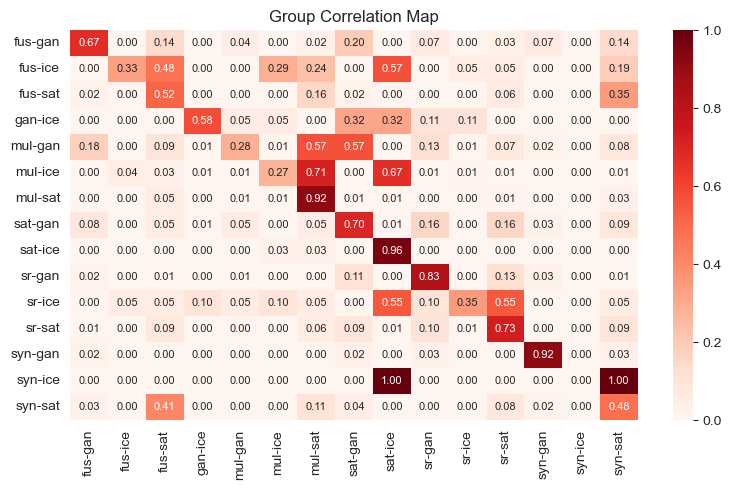

In [17]:
# Plot group correlation matrix as heatmap

fig, ax = plt.subplots(1, 1,
                       figsize=(8, 5))
ax.set_title('Group Correlation Map')
sns.heatmap(group_correlation.drop(['sum'], axis=1),
            cmap='Reds',
            annot=True,
            fmt=".2f",
            annot_kws={'size': 8},
            ax=ax,
            vmin=0,
            vmax=1)
fig.tight_layout()
plt.show()
